# T000 · NeuralPLexer an easy-to-follow usage guide

Authors:

- Katharina Buchthal 2024 Volkamerlab, Saarland University, Germany
- Maximilian Bähr 2024 Volkamerlab, Saarland University, Germany


## Aim of this talktorial


**NeuralPlexer** is an innovative open-source tool that combines **protein structure prediction** with **protein-ligand binding pose prediction**, utilizing the protein sequence as input. At its core, the tool employs a deep learning model that leverages a **diffusion process** to generate predicted ligand  binding poses. 
While the tool has demonstrated superior performance compared to state-of-the-art docking tools, its adoption has been somewhat limited by the scarcity of available sample usage examples.
Therefore, we aim to provide a tutorial that introduces the NeuralPlexer tool and its capabilities, and gives an **easy-to-follow usage guide** to predict ligand binding poses for a given protein - such as protein-ligand complexes.

### Contents in *Theory*

* Score-Based Generative Modeling
* NeuralPLexer Model

### Contents in *Practical*

* NeuralPLexer Installation
* Introduction to NeuralPLexer
* Visualizing the Diffusion Process
* Protein-ligand structure prediction
    * Protein-ligand structure prediction with NeuralPLexer
    * Ramachandran Plot
    * Comparison with cocrystallized protein structure
* Comparison to docking algorithm
    * Ligand binding pose prediction with NeuralPLexer
    * Ligand binding pose prediction using docking
    * Visualizing NeuralPLexer and docking results 
    * Comparing the RMSDs against cocrystallized ligand

### References

* NeuralPLexer paper: [<i>Nature Machine Intelligence</i> (2024), <b>6</b>, 195–208](https://www.nature.com/articles/s42256-024-00792-z)
* Overview on Diffusion Models: [<i>IEEE Transactions on Pattern Analysis and Machine Intelligence.</i> (2023), <b>45</b>, 10850-10869](https://doi.org/10.1109/TPAMI.2023.3261988) 
* Publications on score-based models using SDEs: 
    * [<i>Advances in neural information processing systems.</i> (2019), <b>32</b>, 612-620](https://arxiv.org/abs/1907.05600) 
    * [<i>International Conference on Learning Representations.</i> (2020)](https://arxiv.org/abs/2011.13456)
* SE(3)-transformers: [<i>Advances in Neural Information Processing Systems</i> (2021), <b>33</b>, 1970-1981](https://proceedings.neurips.cc/paper/2020/file/15231a7ce4ba789d13b722cc5c955834-Paper.pdf)
* Useful tutorials:
    * [Interactive data analysis with NGLView: Make a movie](https://ambermd.org/tutorials/analysis/tutorial_notebooks/nglview_movie/index.html)
    * [Protein Superposition using Biopython](https://warwick.ac.uk/fac/sci/moac/people/students/peter_cock/python/protein_superposition/)
    * [Ramachandran Plot](https://docs.mdanalysis.org/1.1.0/documentation_pages/analysis/dihedrals.html)
    * [__Talktorial T015__](https://projects.volkamerlab.org/teachopencadd/talktorials/T015_protein_ligand_docking.html) (Docking)
    * [__Talktorial T036__](https://projects.volkamerlab.org/teachopencadd/talktorials/T036_e3_equivariant_gnn.html) (E(3)-equivariance)
* Tools used:
    * [Biopyhton](https://biopython.org/)
    * [MDAnalysis](https://docs.mdanalysis.org/1.1.0/index.html) ([<i>J. Comput. Chem.</i> (2011), <b>32</b>, 2319–2327](https://doi.org/10.1002/jcc.21787), [<i>J. Proceedings of the 15th Python in Science Conference.</i> (2016)](https://doi.org/10.25080/Majora-629e541a-00e))
    * [MDTrajectory](https://mdtraj.org/1.9.4/index.html) ([<i>Biophysical Journal</i> (2015), <b>109</b>, 1528-1532](https://doi.org/10.1016/j.bpj.2015.08.015))
    * [NGLView](https://github.com/nglviewer/nglview) ([<i>Bioinformatics</i> (2018), <b>34</b>, 1241–1242](https://doi.org/10.1093/bioinformatics/btx789))
    * [RDKit](https://www.rdkit.org/) 
    * [Smina](https://sourceforge.net/projects/smina/) ([<i>J Chem Inf Model</i> (2013), <b>53</b>, 1893-1904](https://doi.org/10.1021/ci300604z))
    

## Theory
Within the theoretical part of this Talktorial, we will discuss the architecture of NeuralPLexer ([<i>Nature Machine Intelligence</i> (2024), <b>6</b>, 195–208](https://www.nature.com/articles/s42256-024-00792-z)). Since a diffusion model is a key component of NeuralPLexer, we will first talk about score-based generative modeling before covering the different parts of NeuralPLexer.

### Score-Based Generative Modeling
Score-based generative models are an approach for generating complex data - such as protein–ligand complexes - through the simulation of a reverse diffusion (denoising) process from a prior distribution. The core concept of such diffusion-based models involves simulating a diffusion process by progressively adding noise to the data, and learning how to reverse this *forward diffusion* process to reconstruct the original data. Accordingly, such models consist of two components:
* **forward process** that gradually adds noise to the data,
* and the **backward process**, which aims to progressively denoise the data. 
While the forward process can be simulated by adding *Gaussian* noise, we want to learn how to revert this, i.e., learning the backward process.

In the following, we will discuss, how these processes can be modeled as stochastic differential equations (SDEs) similar to the approach in NeuralPLexer. Since Yang Song *et al.* introduced and described score-based generative modeling through SDEs, the following explanation and notations are based on their work ([<i>Advances in neural information processing systems.</i> (2019), <b>32</b>, 612-620](https://arxiv.org/abs/1907.05600), [<i>International Conference on Learning Representations.</i> (2020)](https://arxiv.org/abs/2011.13456)). Afterward, we will briefly touch on the adaptations made by Zhuoran Qiao *et al.* for NeuralPLexer ([<i>Nature Machine Intelligence</i> (2024), <b>6</b>, 195–208](https://www.nature.com/articles/s42256-024-00792-z)).

![Diffusion Schematic](./images/diffusion_schematic.png)

*Figure 1:* 
**Solving a reverse-time SDE yields a score-based generative model.** Transforming data to a simple noise distribution can be accomplished with a continuous-time SDE. This SDE can be reversed if we know the score of the distribution at\ each intermediate time step, $\nabla_x \log{p_t(x)}$.
Figure and description taken from: [<i>International Conference on Learning Representations.</i> (2020)](https://arxiv.org/abs/2011.13456).

Both of these process - the forward and backward process - can be described by stochastic differential equations (SDEs) as shown in *Figure 1*: a forward-time SDE, and a backward-time SDE. Here, $x(0)$ represents the (original) denoised data following the data distribution $p_0$, whereas $x(T)$ follows the prior distribution $p_T$. $f(\cdot,t)$ is the drift coefficient of $x(t)$, $g(\cdot)$ is called the diffusion coefficient, and $w$ the Wiener process. The forward-time SDE models the diffusion process $\{x(t)\}^T_{t=0}$ from which we want to learn the reversing process. To reverse the process with backward-time SDE, we need the score function $\nabla_x \log{p_t(x)}$ of the time-dependent data distribution. The score function represents the direction in which to drift to increase the likelihood of the data at the time $t$ and thus moves the data towards the target distribution. Since $p_t(x)$ is unknown, we need to estimate the score function. By learning a score function $s_\theta$, where $\theta$ are the model parameters, we can learn how to reverse diffusion or noisy data back to its (predicted) original form. The score function can be learned with a Neural Network using denoising score matching. However, in the scope of this notebook, we won't discuss this in detail. For more information on this, please refer to the work of Yang Song *et al.* ([<i>Advances in neural information processing systems.</i> (2019), <b>32</b>, 612-620](https://arxiv.org/abs/1907.05600), [<i>International Conference on Learning Representations.</i> (2020)](https://arxiv.org/abs/2011.13456)) and Zhuoran Qiao *et al.* ([<i>Nature Machine Intelligence</i> (2024), <b>6</b>, 195–208](https://www.nature.com/articles/s42256-024-00792-z)).

Although we will cover the different modules of the NeuralPLexer model in the next section, let's briefly discuss how these SDEs were adapted within NeuralPLexer ([<i>Nature Machine Intelligence</i> (2024), <b>6</b>, 195–208](https://www.nature.com/articles/s42256-024-00792-z)). Zhuoran Qiao *et al.* formulated the multivariant SDEs integrating protein-ligand contact maps (we will talk about how this contact maps are generated  in the next section). This enables sampling the structure in a hierarchical manner when applying the reverse SDE. Here, a linear transformation allows removing local atomic structures before removing the global information on protein domain packing and ligand binding interfaces during the forward process. Thus, this models the global packing of protein domains and ligand binding interfaces prior the local atomic structures during the backward/sampling process.  
Further, for the reverse-time SDE, Zhuoran Qiao *et al.* adapt the temperature-adjusted SDE Langevin-simulated annealing SDE (LSA SDE) to obtain more crystal-like complex structures ([<i>Nature Machine Intelligence</i> (2024), <b>6</b>, 195–208](https://www.nature.com/articles/s42256-024-00792-z)). This involves introducing an inverse temperature parameter $\beta(t)$ into the reverse-time SDE. The parameter  is varied during the denoising steps towards a target inverse temperature. 

### The NeuralPlexer model
NeuralPLexer [<i>Nature Machine Intelligence</i> (2024), <b>6</b>, 195–208](https://www.nature.com/articles/s42256-024-00792-z)  revolutionizes protein structure prediction by simultaneously determining protein shapes and drug binding positions. The model outperforms existing tools by directly predicting protein-ligand complexes using only protein sequences and ligand molecular graphs as input. Its ability to model both unbound and drug-bound protein states makes it particularly valuable for drug discovery research.  
At its core, NeuralPlexer combines multiple machine learning models to predict protein-ligand complexes and their confidence scores through a stochastic diffusion process.  
Understanding NeuralPlexer's network architecture and information flow reveals how it achieves these capabilities.  
In this section we discuss all modules of the NeuralPLexer model to understand its overall idea and functionality. 

![components of neuralplexer as shown in their paper](./images/neuralplexerComponents.png)
*Figure 1:* 
Method overview. To perform
predictions, the input protein sequence is first used to retrieve PLM features
and structure templates; NeuralPLexer then combines the set of PLM and
template features with molecular graph representations of the input ligands
to directly sample an ensemble of binding complex structures via a multiscale
generative model. The main network of NeuralPLexer is composed of a
coarse-grained, auto-regressive CPM and an atomistic, diffusion-based ESDM.
Figure and description taken from: [<i>Nature Machine Intelligence</i> (2024), <b>6</b>, 195–208](https://www.nature.com/articles/s42256-024-00792-z).

#### Model input
The NeuralPLexer model processes two types of inputs: proteins and ligands. Protein inputs are represented as single letter amino acid sequences. Ligand inputs are given as molecular graphs, which capture the complete chemical structure including atomic numbers, bond types, and stereochemistry labels.
> **Primary input:**  
>  
> Small molecular graph $\{G\}$   
> Protein sequences $\{s\}$. 

NeuralPLexer does not only requires simple protein-ligand inputs, it also requires **two** auxiliary inputs.  
Templates can be provided by two input options: Either users can provide their own template structure(s) in PDB format or templates will be generated based on the sequences through protein structure prediction networks, which are integrated directly into NeuralPLexer.  
NeuralPLexer also employs Transformer-based Protein Language Models (PLMs) to generate auxiliary input embeddings based on the sequence(s). 

> **Secondary input:**  
>  
>  Embeddings $\{e\}$ = PLM($\{s\}$)   
>  Protein structure templates $\{t\}$: StructurePrediction($\{s\}$) **OR** user-provided

#### Encoding and contact prediction

The encoding module processes protein sequences, embeddings and molecular graphs. Its graph-based network encodes chemical and geometric features into tensor representations. The module directly interfaces with the contact prediction module.  
  
The Contact Prediction Module (CPM) uses an attention network to iteratively predict spacial ligand-protein interactions for each ligand frame, i.e., the implied triangle when two adjacent chemical bonds are taken as vertices. It maintains a residue-scale graph representation of spacial and chemical proximity of the Protein and the ligand. It divides protein residues into 96 bins and ligand frames into 32 bins to generate a coarse-grained contact map (which of those blocks interact with each other based on spacial proximity). This map and the graph representation are then passed to the ESD module.  
  
> **Input:**  
>   
> sequences $\{s\}$, embeddings $\{e\}$, molecular graphs $\{G\}$ and templates $\{t\}$

> **Generating:**  
>   
> Pair representation of ligand and protein  
> Residue scale intermolecular distance graph

>  **Output:** 
>      
> Coarse-grained contact map  
> Updated residue scale intermolecular distance graph


#### Equivariant structure denoising
The module employs a structured denoising diffusion process to predict protein-ligand binding complexes. As explained in the previous section about [Diffusion Processes](#score-based-generative-modeling), it hierarchically generates the complex structure by combining outputs from the CPM and the Encoding module. The denoising process includes a temperature-adjusted Langevin-simulated annealing SDE, which introduces an inverse temperature parameter that gradually changes.


Zhuoran Qiao *et al.* claim that the diffusion model is equivariant to translations and rotations ([<i>Nature Machine Intelligence</i> (2024), <b>6</b>, 195–208](https://www.nature.com/articles/s42256-024-00792-z)). For further details on E(3)-equivariance refer to [__Talktorial T036__](https://projects.volkamerlab.org/teachopencadd/talktorials/T036_e3_equivariant_gnn.html).


> **Input:**  
>  
> SDE with pre-learned score function  
> Contact maps  
> Residue scale intermolecular distance graph 

> **Output:**  
>   
> Ligand-bound structures and confidence estimations

## Practical
In this Talktorial, we will employ [NeuralPLexer](https://github.com/zrqiao/NeuralPLexer) to perform several structure prediction tasks. Before that, we will first show how NeuralPLexer can be installed, and give a short introduction on NeuralPLexer command line tool.

In [1]:
# imports
import os
import subprocess
from pathlib import Path

import Bio.PDB
import matplotlib.pyplot as plt
import MDAnalysis as mda
import mdtraj
import nglview as nv
from MDAnalysis.analysis.dihedrals import Ramachandran
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdMolAlign
from rdkit.Chem.Draw import MolsToGridImage

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

### NeuralPLexer Installation
In this section, we will install NeuralPLexer, including its required environment. To this end, we will (1) clone the repository, (2) create the conda environment, and (3) install NeuralPLexer itself. Note that the installation was only tested for Linux, and might only work for machines with Cuda capable graphic cards. In case, NeuralPLexer cannot be installed, we provide all generated files that are required for this notebook within the `data` directory.

If you already have NeuralPLexer installed, or NeuralPLexer cannot be installed on your machine, this section can be skipped. 

If you intend to use WSL (Windows Subsystem for Linux), you can check the following versions:

- **WSL-Version**: 2.3.26.0  
- **Kernelversion**: 5.15.167.4-1  
- **WSLg-Version**: 1.0.65  
- **MSRDC-Version**: 1.2.5620  
- **Direct3D-Version**: 1.611.1-81528511  
- **DXCore-Version**: 10.0.26100.1-240331-1435.ge-release  
- **Windows-Version**: 10.0.22621.4317  

Environment Setup:

- **conda**: 24.5.0  
- **Python**: 3.10.16  
- **pip**: 22.0.2  

**Note**: The installation can work on other versions, but in the scope of this installation, we will stick to these versions.

Before we will start with the installation, we define a tiny helper function that allows us to run a shell command, to check whether it succeed using the pyhton `subprocess` package. Later, we will need to run shell commands within the NeuralPLexer environment `neuralplexer_dev` - mainly when running NeuralPLexer itself. For that purpose, we use the `envrionment` parameter. If `envrionment` is set, we execute the command within the given conda environment using `conda run -n <envrionment> <command>`. Further, when we will later run NeuralPLexer, we need to specify where the python runtime looks for new modules to import, for that purpose, we use the variable `use_pyhton_directive`.

In [3]:
def run_shell_command(
    cmd,
    description="",
    environment=None,
    use_python_directive=False,
    print_success=True,
    suppress_output=False,
):
    """
    Executes shell command using subprocess and checks wether is succeeds.
    If environment is given, this command is executed in this environment.

    Parameters
    ----------
    cmd: str
        Command that should be executed
    description: str
        Description of success (will be printed in case of success)
    environment: str
        Existing (!) conda environment. If specified, cmd will be executed in this environment
    use_python_directive: boolean @Max naming
        If true, PYTHONPATH=$PYTHONPATH:$(pwd) is prepended to the command.
        This is needed to execute python scripts when using conda run -n (? @Max)
    print_success: boolean
        If true, also prints message when cmd was successfully executed
    suppress_output: boolean
        If true, std output is suppressed
    """

    full_command = (
        (
            "PYTHONPATH=$PYTHONPATH:$(pwd) " if use_python_directive else ""
        )  # add python path
        + (
            f"conda run -n {environment} " if environment else ""
        )  # if given, set conda environment
        + cmd
    )

    print("Running", full_command)

    # run command
    res = subprocess.run(full_command, shell=True, capture_output=suppress_output)

    # check if cmd is executed succesfully
    if res.returncode != 0:
        # error occured
        print(f"Error when executing {full_command}")
        if suppress_output:
            print(res.stderr)
    elif print_success:
        # print success
        print(f"Successfully {description}")

(1) Clone the repository into the current directory:

In [4]:
run_shell_command(
    "git clone https://github.com/zrqiao/NeuralPLexer.git",
    "cloned repository",
    suppress_output=True,
)

Running git clone https://github.com/zrqiao/NeuralPLexer.git
Successfully cloned repository


(2) Create the NeuralPLexer environment from `NeuralPLexer/environment_dev.yaml`:

**Note:** This might take a while (~2-5 minutes).

In [5]:
run_shell_command(
    "conda env create -f NeuralPLexer/environment_dev.yaml",
    "created conda environment",
    suppress_output=True,
)

Running conda env create -f NeuralPLexer/environment_dev.yaml
Successfully created conda environment


(3) Install NeuralPLexer within `neuralplexer_dev` environment:

In [6]:
run_shell_command(
    "pip install -e NeuralPLexer",
    "installed NeuralPLexer",
    environment="neuralplexer_dev",
    suppress_output=True,
)

Running conda run -n neuralplexer_dev pip install -e NeuralPLexer


Let's test whether NeuralPLexer is successfully installed:

In [7]:
run_shell_command(
    "neuralplexer-inference --help", environment="neuralplexer_dev", print_success=False
)

Running conda run -n neuralplexer_dev neuralplexer-inference --help
usage: neuralplexer-inference [-h] --task TASK [--sample-id SAMPLE_ID]
                              [--template-id TEMPLATE_ID] [--cuda]
                              [--model-checkpoint MODEL_CHECKPOINT]
                              [--input-ligand INPUT_LIGAND]
                              [--input-receptor INPUT_RECEPTOR]
                              [--input-template INPUT_TEMPLATE]
                              [--out-path OUT_PATH] [--n-samples N_SAMPLES]
                              [--chunk-size CHUNK_SIZE]
                              [--num-steps NUM_STEPS]
                              [--latent-model LATENT_MODEL] --sampler SAMPLER
                              [--start-time START_TIME]
                              [--max-chain-encoding-k MAX_CHAIN_ENCODING_K]
                              [--exact-prior] [--discard-ligand]
                              [--discard-sdf-coords] [--detect-covalent]
    

If you see the NeuralPLexer help text, you successfully installed NeuralPLexer.

**Note:** On WSL, there might be some versioning problems with `torch_scatter`. **Only run the following cell** if running the previous cell produces an  **undefined symbol** error. This cell will uninstall `torch_scatter` and reinstall the correct version of it. After running this, the previous cell should run successfully. 

In [8]:
# uninstall torch-scatter
run_shell_command(
    "pip uninstall torch-scatter -y",
    "uninstalled torch-scatter",
    environment="neuralplexer_dev",
    suppress_output=True,
)

# get version
result = subprocess.run(
    "conda run -n neuralplexer_dev python -c 'import torch; print(torch.__version__)'",
    shell=True,
    capture_output=True,
    text=True,
)
version = result.stdout.rstrip("\n")

# reinstall correct torch-scatter version
run_shell_command(
    f"pip install torch-scatter -f https://data.pyg.org/whl/torch-{version}+cpu.html",
    f"installed torch-scatter {version}",
    environment="neuralplexer_dev",
    suppress_output=True,
)

Running conda run -n neuralplexer_dev pip uninstall torch-scatter -y
Successfully uninstalled torch-scatter
Running conda run -n neuralplexer_dev pip install torch-scatter -f https://data.pyg.org/whl/torch-2.4.1+cpu.html


### NeuralPLexer Introduction
After installing NeuralPLexer, we can use it to predict protein-ligand complex conformations. To simplify its usage, we introduce a wrapper function that calls NeuralPLexer as a subprocess, making it easier to configure several program parameters. As you may have noticed, running NeuralPLexer with the `--help` option shows numerous program options that can be configured. Further, NeuralPLexer allows us to execute different tasks. Before, implementing this wrapper function, let's first discuss the different tasks and some of these parameters. Note that due to a limited of documentation, we only infer the purpose of these parameters, but we cannot ensure correctness. 

**Tasks:**
- `single_sample_trajectory` - performs protein-ligand complex conformations and outputs all stages of the diffusion process,
- `batched_structure_sampling` - performs protein-ligand complex conformations and outputs `n_sample` conformations.

Further, NeuralPLexer provides three benchmarking tasks that were used for their paper: `structure_prediction_benchmarking`, `pdbbind_benchmarking`, and `binding_site_recovery_benchmarking`.

**Program parameters:**
| Parameter                      | Description                                                                                                                                                                                                                                                                                   |
|----------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `--input-receptor INPUT_RECEPTOR`| Input protein, this can be a protein sequence (single letter code) or a PDB file.                                                                                                                                                                                                              |
| `--input-ligand INPUT_LIGAND`    | Input ligand(s), which can be a SMILES sequence or a file in the following formats: msgpack, sdf, mol2, or PDB.  Multiple ligands should be separated with '\|'                                                                                                                                                                                 |
| `--out-path OUT_PATH`            | Directory where output files should be saved.                                                                                                                                                                                                                                                  |
| `--n-samples N_SAMPLES`          | Number of samples (e.g., conformations) to generate. In the scope of this notebook, we will default this to one conformation.                                                                                                                                                                 |
| `--num-steps NUM_STEPS`          | Number of steps for the diffusion process (default is 100).                                                                                                                                                                                                                                   |
| `--chunk-size CHUNK_SIZE`        | Size of data chunks to process at a time.                                                                                                                                                                                                                                                      |
| `--use-template`                 | If true, a template (`INPUT_TEMPLATE`) is used. Useful if only the ligand conformation should be predicted and the protein is rigid.                                                                                                                                                          |
| `--input-template INPUT_TEMPLATE`| PDB file of the template.                                                                                                                                                                                                                                                                     |
| `--cuda`                         | If true, the calculations are done on a GPU using CUDA. To ensure compatibility with more machines, this will be disabled throughout the notebook. However, you can enable it by setting the corresponding flag.                                                                               |
| `--model-checkpoint MODEL_CHECKPOINT`| Path to the pre-trained model checkpoint.                                                                                                                                                                                                                                                |
| `--sampler SAMPLER`              | Sampler method for the diffusion process. Possible samplers are: DDIM, VPSDE, simulated_annealing_simple, and langevin_simulated_annealing. Throughout this notebook, we will use langevin_simulated_annealing, as it was used in the benchmarking tasks.                                        |
| `--rank-outputs-by-confidence`   | Ranks outputs based on confidence scores. If this option is enabled, the outputs are annotated with a confidence score.                                                                                                                                                                        |

**Note:**
* As NeuralPLexer is not installable on all machines, we provide all structures that are computed with NeuralPLexer within the [data](data) directory.  
* To the best of our knowledge, NeuralPLexer does not offer an option to set a seed ([#59](https://github.com/zrqiao/NeuralPLexer/issues/59)), which may result in variations from the pre-calculated results. Our analysis and conclusions are based on the pre-calculated NeuralPLexer structures available in the [data](data) directory.

In [18]:
def run_neuralplexer(
    task,
    protein,
    out_path,
    path_model,
    ligand=None,
    sampler="langevin_simulated_annealing",
    num_steps=100,
    n_samples=1,
    chunk_size=1,
    use_cuda=False,
    template=None,
    output_confidence=False,
):
    """
    Runs the NeuralPLexer with the specified configuration as a subprocess.

    Parameters
    ----------
    task : str
        Task to perform, possible options are: 'single_sample_trajectory', 'batched_structure_sampling',
        'structure_prediction_benchmarking', 'pdbbind_benchmarking', and 'binding_site_recovery_benchmarking'.
    protein : str
        Input protein, which can be a protein sequence (single letter code) or a PDB file.
    out_path : str
        Directory where output files should be saved.'
    path_model : str
        Path to the pre-trained model checkpoint to be used.
    ligand : str, optional
        Input ligand(s), which can be a SMILES sequence or a file in formats such as msgpack,
        sdf, mol2, or PDB. Multiple ligands should be separated with '\|
    sampler : str, optional
        Sampler method for the diffusion process. Default is "langevin_simulated_annealing".
        Possible options: DDIM, VPSDE, simulated_annealing_simple, langevin_simulated_annealing.
    num_steps : int, optional
        Number of steps for the diffusion process. Default is 100.
    n_samples : int, optional
        Number of samples (e.g., conformations) to generate. Default is 1.
    chunk_size : int, optional
        Size of data chunks to process at a time. Default is 1.
    use_cuda : bool, optional
        If true, the calculations are done on a GPU using CUDA. Default is False.
    template : str, optional
        PDB file of the template. If provided, it is used for templated predictions.
    output_confidence : bool, optional
        If true, ranks outputs based on confidence scores and annotates the outputs with a confidence score.
        Default is False.

    """

    cmd = (
        f"neuralplexer-inference --task {task} --input-receptor {protein} --out-path {out_path} "
        + f"--model-checkpoint {path_model} --sampler {sampler} --n-samples {n_samples} "
        + f"--chunk-size {chunk_size} --num-steps {num_steps} "
        + (f"--input-ligand {ligand} " if ligand else "")
        + (f"--use-template --input-template {template} " if template else "")
        + ("--cuda " if use_cuda else "")
        + ("--rank-outputs-by-confidence" if output_confidence else "")
    )

    run_shell_command(cmd, f"performed {task} task", environment="neuralplexer_dev", suppress_output=True)

Now, we are almost ready to play around with NeuralPLexer. However, we need to provide NeuralPLexer a pre-trained model, as well as, a protein and ligand of interest. The pre-trained model can be obtained from [zenodo](https://doi.org/10.5281/zenodo.10373581), and should be placed into [data/models](data/models) directory, for more information, please refer to the [README](data/models) with this directory. 

In [10]:
model = DATA / "models" / "complex_structure_prediction.ckpt"

We will apply NeuralPLexer to the Kanamycin B protein, a transmembrane protein, and use the co-crystallized PDB structure [6NP5](https://www.rcsb.org/structure/6np5) as comparison and assess the results. Further, we will use the co-crystallized ligand (9CS). It is important to note that this structure was **not** in the training set of NeuralPLexer.

In [11]:
protein_sequence = (
    "TPWSKSELVRQLRDLGVRSGDMVMPHVSLRAVGPLADGPQTLVDALIEAVGPTGNILAFVSWRDSPYEQTLGHDAPPAAIAQSWPAFDPDH"
    + "APAYPGFGAINEFIRTYPGCRRSAHPDASMAAIGPDAAWLVAPHEMGAAYGPRSPIARFLAHAGKILSIGAGPDAVTALHYAEAVARIE"
    + "GKRRVTYSMPLLREGKRVWVTTSDWDSNGILDEYAAPDGPDAVERIARDYLARTRVAQGPVGGAQSRLIDAADIVSFGIEWLEARHAA"
)
ligand_smiles = (
    "NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[C@H](CO)[C@@H]"
    + "(O)[C@H](N)[C@H]3O)[C@H](N)C[C@@H]2N)[C@H](N)[C@@H](O)[C@@H]1O"
)
complex_pdb = "6np5"

Ligand 9CS:


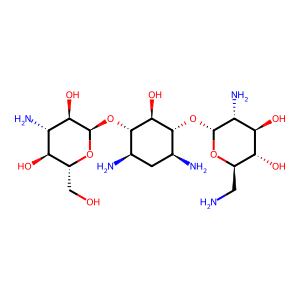

In [12]:
print("Ligand 9CS:")
Draw.MolToImage(Chem.MolFromSmiles(ligand_smiles))

**Note:** Since NeuralPLexer seems to fail to generate conformers for some SMILE inputs (e.g. [#43](https://github.com/zrqiao/NeuralPLexer/issues/43) in GitHub), we will use an SDF molecule file with all coordinates are set to zero as ligand input.

In [13]:
path_input_ligand = DATA / complex_pdb / "ligand_zero_coordinates.sdf"

### Visualizing the Diffusion Process
As a first example of using NeuralPLexer, we will employ the single trajectory task and predict a conformation of the protein (without the ligand). Using this, we can see, how NeuralPLexer stepwise predicts the protein-ligand complex conformation. Thus, we will first run NeuralPLexer and secondly generate a movie from the resulting frames to showcase the diffusion process. 

**Note:** Due to a potential bug ([#60](https://github.com/zrqiao/NeuralPLexer/issues/60)), NeuralPLexer does not allow us to input a protein sequence for the single trajectory tasks. Thus, we use a PDB file of the protein as input, where all coordinates are set to zero ([data/6np5/protein_zero_coordinates.pdb](data/6np5/protein_zero_coordinates.pdb)).

In [14]:
input_protein = DATA / complex_pdb / "protein_zero_coordinates.pdb"
out_path_trajectory = DATA / f"results_trajectory_{complex_pdb}"

**Note:** The resulting NeuralPLexer conformation is already pre-calculated. Thus the next cell can also be skipped if - for example - NeuralPLexer is not available on your machine. We provide the pre-calculated results in the [data/results_trajectory_6np5](data/results_trajectory_6np5) directory.

This takes a while (~4-5 minutes).

In [19]:
run_neuralplexer(
    "single_sample_trajectory",
    input_protein,
    str(out_path_trajectory) + "/",
    model,
    ligand=None,
    num_steps=100,
)

Running conda run -n neuralplexer_dev neuralplexer-inference --task single_sample_trajectory --input-receptor /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/6np5/protein_zero_coordinates.pdb --out-path /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/results_trajectory_6np5/ --model-checkpoint /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/models/complex_structure_prediction.ckpt --sampler langevin_simulated_annealing --n-samples 1 --chunk-size 1 --num-steps 100 
Successfully performed single_sample_trajectory


Successfully 


To show the steps of the conformation prediction process, we load the conformations as a trajectory the mdtraj package and visualize them interactively using NGLView.

In [20]:
traj = mdtraj.load(out_path_trajectory / "_prot.pdb")
view = nv.show_mdtraj(traj)
view

NGLWidget(max_frame=100)

In [22]:
_ = view.render_image(trim=True, factor=2)

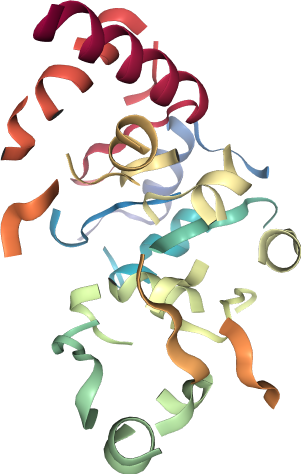

In [23]:
view._display_image()

When running the movie, we can see that the protein is moving rapidly in the beginning but seem to converge to one conformation in the end. However, we see that even in the end, the chain seems to be discontinuous, and might not represent a true conformation. Let's take a closer look at this and inspect the final conformation in detail.

In [24]:
view = nv.show_file(str(out_path_trajectory / "_prot_final.pdb"), ext="pdb")
view.add_ball_and_stick()
view

NGLWidget()

In [25]:
_ = view.render_image(trim=True, factor=2)

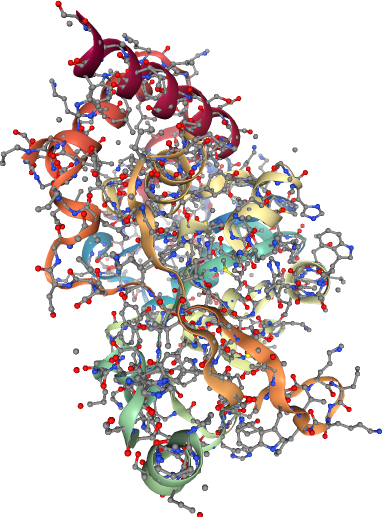

In [26]:
view._display_image()

When inspecting the conformation with all residues explicitly displayed, we notice that the chain is indeed discontinuous - i.e., there are some missing peptide bonds. Some residues - or more specific, their atoms seem to be placed too far away from each other. We also see this for some single atoms, that are placed too far to detect a covalent bond. As this was already reported in several issues on Github ([#40](https://github.com/zrqiao/NeuralPLexer/issues/40), [#41](https://github.com/zrqiao/NeuralPLexer/issues/41), and [#58](https://github.com/zrqiao/NeuralPLexer/issues/58)), this might showcase a limitation of NeuralPLexer.

Let's see how NeuralPLexer performs when predicting the whole protein-ligand complex conformation.

### Protein-ligand structure prediction
In this section, we will use NeuralPLexer to predict the whole protein ligand structure of the Kanamycin B protein with ligand 9CS. To assess the resulting structure, we will compare the result with the co-crystallized structure ([6NP5](https://www.rcsb.org/structure/6np5)) using a Ramachandran plot, as well as, a visual inspection of the structures. 

#### Protein-ligand structure prediction with NeuralPLexer
We first run NeuralPLexer using the `batched_structure_sampling` task.

In [27]:
# define output path
out_path_complex_prediction = DATA / f"results_flexible_receptor_{complex_pdb}"

**Note:** The next cell can also be skipped. We provide the pre-calculated results in [data/results_flexible_receptor_6np5](data/results_flexible_receptor_6np5) directory.

In [28]:
run_neuralplexer(
    "batched_structure_sampling",
    protein_sequence,
    out_path_complex_prediction,
    model,
    path_input_ligand,
)

Running conda run -n neuralplexer_dev neuralplexer-inference --task batched_structure_sampling --input-receptor TPWSKSELVRQLRDLGVRSGDMVMPHVSLRAVGPLADGPQTLVDALIEAVGPTGNILAFVSWRDSPYEQTLGHDAPPAAIAQSWPAFDPDHAPAYPGFGAINEFIRTYPGCRRSAHPDASMAAIGPDAAWLVAPHEMGAAYGPRSPIARFLAHAGKILSIGAGPDAVTALHYAEAVARIEGKRRVTYSMPLLREGKRVWVTTSDWDSNGILDEYAAPDGPDAVERIARDYLARTRVAQGPVGGAQSRLIDAADIVSFGIEWLEARHAA --out-path /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/results_flexible_receptor_6np5 --model-checkpoint /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/models/complex_structure_prediction.ckpt --sampler langevin_simulated_annealing --n-samples 1 --chunk-size 1 --num-steps 100 --input-ligand /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/6np5/ligand_zero_coordinates.sdf 
Successfully performed batched_structure_sampling


In [29]:
with open(out_path_complex_prediction / "prot_all.pdb") as f:
    view = nv.show_file(f, ext="pdb")
with open(out_path_complex_prediction / "lig_all.sdf") as f:
    view.add_component(f, ext="sdf")
view

NGLWidget()

In [30]:
_ = view.render_image(trim=True, factor=2)

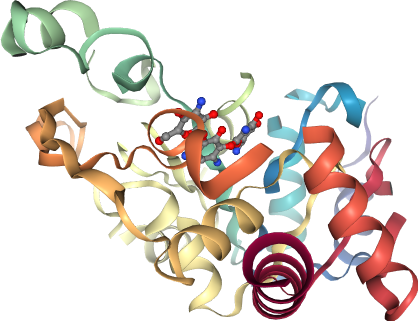

In [31]:
view._display_image()

Here, we see the predicted complex conformation. The ligand seems to be interacting with the protein, and there seems to be no clashes. However, when inspecting the protein conformation, we again observe that the chain is discontinuous in some areas.

#### Ramachandran Plot
To assess the secondary structure of the predicted protein conformation, we use a Ramachandran plot. This plot represents the distribution of the two dihedral angles, $\phi$ and $\psi$, of the protein's backbone. This distribution can be then used to assess whether the protein conformation adapts common secondary structure, such as $\alpha$-helix, or $\beta$-sheet, , and whether the angles are physicochemical *allowed*.  
To calculate the dihedral angles and plot them, we use the MDAnalysis package and MathPlotLib. To this end, we first load the protein conformation as an MDAnalysis Universe, and calculate the dihedral angles using the Ramachandran class. As a reference, we “allowed region” and the “marginally allowed” regions in blue on the plot.

In [33]:
# load protein
u = mda.Universe(DATA / f"results_flexible_receptor_{complex_pdb}" / "prot_all.pdb")

# calculate dihedral angles
R = Ramachandran(u).run()

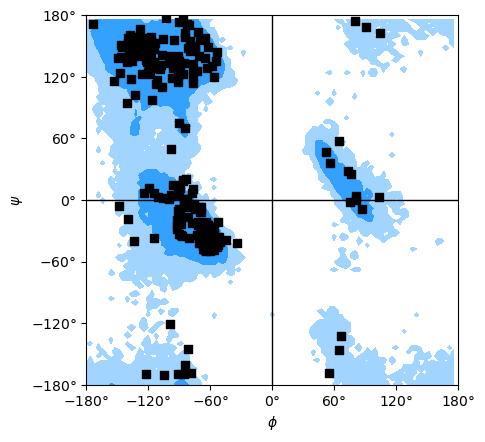

In [34]:
# plot the angles
fig, ax = plt.subplots(figsize=plt.figaspect(1))
R.plot(ax=ax, color="k", marker="s", ref=True)

plt.show()

When looking at the resulting plot, we see that most residue conformations are within the “marginally allowed” regions, suggesting that their conformations are physicochemical feasible. Further, we notice that there is a high density in the area in the top-right corner ($\alpha$-helix), and in the center on the right ($\beta$-sheet). 

#### Comparison with cocrystallized protein structure 
To compare the original protein-ligand structure with the predicted one, we need to superimpose the two complex conformations first. During superimposition, a rotation and translation of a given protein is determined that minimizes the RMSD to the reference structure. Accordingly, the two structures are aligned without changing the relative positions of the atoms.

In [35]:
path_protein = DATA / complex_pdb / "protein.pdb"

In [36]:
def superimpose(ref_structure, predicted_structure):
    """
    Superimposes a predicted structure to a reference structure,
    assuming the sequence of both proteins are equal and returns the minimized the RMSD.

    Parameters
    ----------
    ref_structure : Bio.PDB.Structure
        Reference protein structure
    predicted_structure : Bio.PDB.Structure
        Predicted protein structure

    Returns
    -------
    float
        The RMSD value between the reference and predicted structures after alignment.
    """

    # code adapted from https://warwick.ac.uk/fac/sci/moac/people/students/peter_cock/python/protein_superposition/

    ref_atoms = []
    alt_atoms = []
    for ref_chain, alt_chain in zip(ref_structure, predicted_structure):
        for ref_res, alt_res in zip(ref_chain, alt_chain):
            ref_atoms.append(ref_res["CA"])
            alt_atoms.append(alt_res["CA"])

    super_imposer = Bio.PDB.Superimposer()
    super_imposer.set_atoms(ref_atoms, alt_atoms)

    super_imposer.apply(predicted_structure.get_atoms())

    return super_imposer.rms

In [37]:
ref_structure = Bio.PDB.PDBParser(QUIET=True).get_structure(complex_pdb, path_protein)[
    0
]
predicted_structure = Bio.PDB.PDBParser(QUIET=True).get_structure(
    complex_pdb + "_neuralplexer", out_path_complex_prediction / "prot_all.pdb"
)[0]

rmsd = superimpose(ref_structure, predicted_structure)

print(f"RMSD after superimposition: {rmsd:.3}")

RMSD after superimposition: 2.97


In [38]:
view = nv.show_biopython(ref_structure, default_representation=False)
view[0].add_cartoon(color="green")

view.add_component(nv.BiopythonStructure(predicted_structure))
view[1].clear_representations()
view[1].add_cartoon()

view

NGLWidget()

In [39]:
_ = view.render_image(trim=True, factor=2)

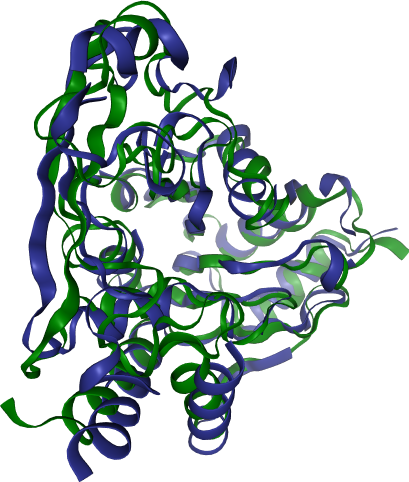

In [40]:
view._display_image()

After aligning (superimposing) the predicted structure to the cocrystallized conformation, we see that both conformation show similar or overlapping regions and seem to fit most secondary motifs rather well, but there are several regions, where both structure derivate by some magnitude. 

### Comparison with docking algorithm
Within this section, we will compare NeuralPLexer with conventional docking. We will use the docking tool [Smina](https://sourceforge.net/projects/smina/) ([<i>J Chem Inf Model</i> (2013), <b>53</b>, 1893-1904](https://doi.org/10.1021/ci300604z)), that performs rigid-body-flexible-ligand docking. To make a *fair* comparison, we will (1) run the  template NeuralPLexer task that will use a given protein structure - here the structure of the input sequence - as a template. (2) we will run docking on that structure, and (3) calculate the RMSD between the respective resulting ligand conformation with the cocrystallized one (6np5).

#### Ligand binding pose prediction with NeuralPLexer
We first run NeuralPLexer using the protein structure as template to generate the ligand pose with a rigid protein (similar to docking).

In [41]:
# define output path and path to template protein
out_path_docking = DATA / f"results_rigid_receptor_{complex_pdb}"
path_ligand_original = DATA / complex_pdb / "ligand.sdf"

To successfully run docking, we calculate a 3D-conformation of the ligand using RDKit. This we will than use as input for both, for docking and for NeuralPLexer. 

In [42]:
# load ligand (with zeroed coordinates)
m = next(Chem.SDMolSupplier(path_input_ligand, removeHs=False))

# generate 3D conformation
AllChem.EmbedMolecule(m)
AllChem.MMFFOptimizeMolecule(m)

# write ligand
path_input_ligand_3d = DATA / complex_pdb / "ligand_3d.sdf"

with Chem.SDWriter(path_input_ligand_3d) as w:
    w.write(m)

**Note:** The next cell can also be skipped. We provide the pre-calculated results in the [data/results_rigid_receptor_6np5](data/results_rigid_receptor_6np5) directory.

This takes a while (~4-5 minutes).

In [43]:
run_neuralplexer(
    "batched_structure_sampling",
    path_protein,
    out_path_docking,
    model,
    ligand=path_input_ligand_3d,
    template=path_protein,
)

Running conda run -n neuralplexer_dev neuralplexer-inference --task batched_structure_sampling --input-receptor /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/6np5/protein.pdb --out-path /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/results_rigid_receptor_6np5 --model-checkpoint /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/models/complex_structure_prediction.ckpt --sampler langevin_simulated_annealing --n-samples 1 --chunk-size 1 --num-steps 100 --input-ligand /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/6np5/ligand_3d.sdf --use-template --input-template /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/6np5/protein.pdb 
Successfully performed batched_structure_sampling


#### Ligand binding pose prediction using docking
For the docking benchmark, we employ the [Smina](https://sourceforge.net/projects/smina/) ([<i>J Chem Inf Model</i> (2013), <b>53</b>, 1893-1904](https://doi.org/10.1021/ci300604z)) docking engine, which was already introduced in the [__Talktorial T015__](https://projects.volkamerlab.org/teachopencadd/talktorials/T015_protein_ligand_docking.html). To pass the binding pocket to Smina, we use the original ligand, from which Smina derives a bounding box. 

In [44]:
run_shell_command(
    f"""smina --ligand {path_input_ligand_3d}\
                    --receptor {path_protein}\
                    --out {out_path_docking / "docking_poses.sdf"}\
                    --autobox_ligand {path_ligand_original}\
                    --num_modes 1 \
                    --exhaustiveness 8\
                    --seed 42""",
    print_success=False,
)

Running smina --ligand /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/6np5/ligand_3d.sdf                    --receptor /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/6np5/protein.pdb                    --out /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/results_rigid_receptor_6np5/docking_poses.sdf                    --autobox_ligand /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/6np5/ligand.sdf                    --num_modes 1                     --exhaustiveness 8                    --seed 42
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Wei

#### Visualizing NeuralPLexer and docking results 
Let's first visually compare the NeuralPLexer and docking results with the original ligand conformation.

In [45]:
def show_multiple_ligands(protein_path, ligand_paths, ligand_names=None, colors=None):
    """
    Visualize a protein with multiple ligands in NGLView.

    Parameters
    ----------
    protein_path : str
        File path to the protein structure (PDB)
    ligand_paths : list(str)
        List of file paths to the ligand structures in SDF format
    ligand_names : list of str, optional
        List of names for the ligands for legend
    colors : list of str, optional
        List of colors to assign to each ligand.

    Returns
    -------
    nv.NGLWidget
        NGLView widget displaying the protein with the specified ligands
    """
    with open(protein_path) as f:
        view = nv.show_file(f, ext="pdb")
    for i, lig_path in enumerate(ligand_paths):
        with open(lig_path) as f:
            view.add_component(f, ext="sdf")
    view.center(component=1)

    if colors:
        print(f"Color scheme:")
        for i, (color, ligand_name) in enumerate(zip(colors, ligand_names)):
            print(f"{color}\t-\t{ligand_name}")
            view[i + 1].clear_representations()
            view.add_representation("licorice", component=i + 1, color=color)

    view.center(component=1)
    return view

In [46]:
view = show_multiple_ligands(
    path_protein,
    [
        path_ligand_original,
        out_path_docking / "docking_poses.sdf",
        out_path_docking / "lig_all.sdf",
    ],
    ["cocrystallized", "docking", "NeuralPLexer"],
    ["gray", "blue", "purple"],
)
view

Color scheme:
gray	-	cocrystallized
blue	-	docking
purple	-	NeuralPLexer


NGLWidget()

In [47]:
_ = view.render_image(trim=True, factor=2)

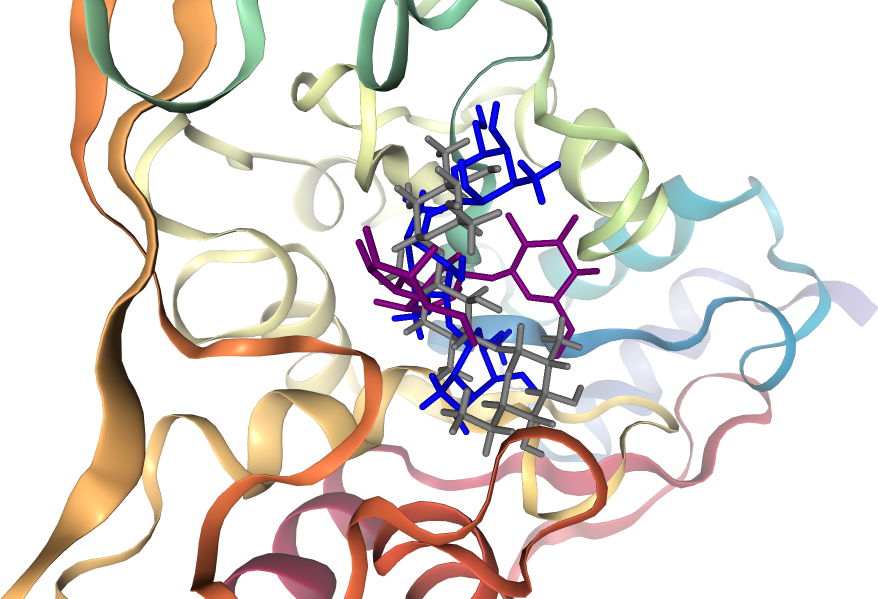

In [48]:
view._display_image()

Comparing the docking (blue) and NeuralPLexer (purple) conformation with the cocrystallized conformation (gray), we observe that the NeuralPLexer solution seems to have a more similar conformation than the docking solution. 

#### Comparing the RMSDs against cocrystallized ligand
To determine how much the docking and respectively NeuralPLexer ligand conformation derivate from the cocrystallized ligand, we calculate the RMSD between the respective conformations. 

[15:14:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


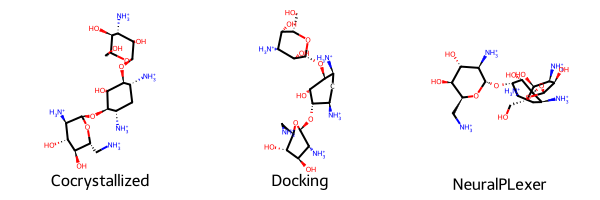

In [49]:
# load ligand conformations
ligand_original = next(Chem.SDMolSupplier(path_ligand_original))
ligand_docking = next(Chem.SDMolSupplier(out_path_docking / "docking_poses.sdf"))
ligand_np = next(Chem.SDMolSupplier(out_path_docking / "lig_all.sdf"))
MolsToGridImage(
    mols=[ligand_original, ligand_docking, ligand_np],
    legends=["Cocrystallized", "Docking", "NeuralPLexer"],
    molsPerRow=3,
)

In [32]:
print(
    f"RMSD between NP ligand pose and cocrystallized pose:\t{rdMolAlign.CalcRMS(ligand_np, ligand_original)}"
)
print(
    f"RMSD between docking pose and cocrystallized pose:\t{rdMolAlign.CalcRMS(ligand_docking, ligand_original)}"
)

RMSD between NP ligand pose and cocrystallized pose:	2.4472793345288815
RMSD between docking pose and cocrystallized pose:	4.191233990705899


Approaching the RMSD, we also see that the NeuralPLexer solution seems to be closer to the cocrystallized ligand than the docking solution. However, since this was only one example, this comparison **cannot** be used to draw any conclusions on general performance of NeuralPLexer.

## Discussion
You now have learned the basic principles of how diffusion processes work and how they are used in Diffusion models. You also have gained a basic understanding of the theoretical background of the NeuralPLexer implementation. Finally you learned how you can use NeuralPLexer and how you can benchmark its performance against Docking.
### Summary:
**NeuralPLexer** is a complex model based on **Stochastical Diffusion Equations** that predicts the **3D Protein-Ligand conformation** of a given protein and ligand. It takes advantage of temperature-adjusted Langevin-simulated annealing (SDE) while denosing to account for minor conformational changes in the ligands.
NeuralPlexer also encooperates Residue- atom- and block level distance information between protein and ligands.
NeuralPLexer, despite its promising advances in drug discovery, has not yet achieved widespread adoption—a situation we aim to address through this tutorial by making its powerful capabilities more accessible to researchers.  

**Strengths:**  
NeuralPLexer offers free access to simultaneous protein-ligand conformation prediction capabilities and shows potential to compete with established tools like AlphaFold in terms of performance. Further, compare to AlphaFold, NeuralPLexer is open source, enabling unlimited access and transparency.
   
**Limitations:**  
Despite its promising features, NeuralPLexer suffers from reproducibility issues, lacks consistent maintenance, and sometimes produces unreliable structural predictions, while its implementation details remain poorly documented in the publication.

### Open Questions:
AlphaFold3 has emerged as a viable competitor since it is also able to predict the binding mode of Protein-Ligand complexes. It remains to be seen in comparison benchmarks which model comes out ahead.  
The adoption of NeuralPlexer has been slow, therefore the question arises if it will be maintained and accepted by the open-source cheminformatics community.



## Quiz
1. What is the difference between a forward-time and a backward process in diffusion models? Which process needs to be learned?
2. What is the purpose of the embedding and contact prediction module of the NeuralPLexer model?
3. What is a Ramachandran plot, and how can we use it to assess a protein structure? 
4. Is it a limitation that NeuralPLexer cannot be set to one seed?
5. How does a superimposition modify the positions of the protein's atoms? Does the superimposition of two proteins change the relative positions of the atoms within each protein? 

<div class="alert alert-block alert-info">

<b>Useful checks at the end</b>: 
    
<ul>
<li>Clear output and rerun your complete notebook. Does it finish without errors?</li>
<li>Check if your talktorial's runtime is as excepted. If not, try to find out which step(s) take unexpectedly long.</li>
<li>Flag code cells with <code># TODO: CI</code> that have deterministic output and should be tested within our Continuous Integration (CI) framework.</li>
</ul>

</div>